# PGA Project

Over the following notebook we will dive into the PGA tour data from 2010 through 2018. I have also created a model to predict the earnings of a player given their peformance over the season. 

Having grown up playing golf for most of my life I have always been interested in how the game is changing and what causes the average players (0 wins) to be seperated from the elite players (1 or more wins). I hope to discover this through exploratory data analysis (EDA) to see what the statistics reveal. 

To predict the players earnings over the season, I implemented multiple machine learning models such as Logistic regression, Polynomial features with Linear regression, Ridge regression, the ensemble method of Random Forest regression as well as using Randomized Search CV in order to tune the hyperparameters further.

I found that I had the best performance with the Random Forest model, producing a R^2 score of 0.94 and a Mean Absolute Error (MAE) of $202154.84 on my test data. Additionally I concluded that the Randomized search CV did not significantly improve this and therefore would not be worth the extra computational expense. 


### Import packages

In [1]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ML packages
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# 1. The Data

We will first begin by importing the data into a dataframe format and inspecting it closer.

Upon inspection we see that the dataframe contains 2312 rows and 18 columns. We have a mixture of data types including floats, ints, and objects. We also have characters in the numeric columns as well as missing values, these will be addressed later.

Below is a brief decreption of each column titles for reference. 

 - Player Name: Name of the golfer.

 - Rounds: The number of games that a player played.

 - Fairway Percentage: The percentage of time a tee shot lands on the fairway.

 - Year: The year in which the statistic was collected.

 - Avg Distance: The average distance of the tee-shot.

 - G.I.R: (Green in Regulation) is met if any part of the ball is touching the putting surface while the number of strokes taken is at least two fewer than par.

 - Average Putts: The average number of strokes taken on the green.

 - Average Scrambling: Scrambling is when a player misses the green in regulation, but still makes par or better on a hole.

 - Average Score: Average Score is the average of all the scores a player has played in that year.

 - Points: The number of FedExCup points a player earned in that year. These points can be earned by competing in tournaments.

 - Wins: The number of competition a player has won in that year.

 - Top 10: The number of competitions where a player has placed in the Top 10.

 - Average SG Putts: Strokes gained: putting measures how many strokes a player gains (or loses) on the greens.

 - Average SG Total: The Off-the-tee + approach-the-green + around-the-green + putting statistics combined.

 - SG:OTT: Strokes gained: off-the-tee measures player performance off the tee on all par-4s and par-5s.

 - SG:APR: Strokes gained: approach-the-green measures player performance on approach shots. Approach shots include all shots that are not from the tee on par-4 and par-5 holes and are not included in strokes gained: around-the-green and strokes gained: putting. Approach shots include tee shots on par-3s.

 - SG:ARG: Strokes gained: around-the-green measures player performance on any shot within 30 yards of the edge of the green. This statistic does not include any shots taken on the putting green.

 - Money: The amount of prize money a player has earned from tournaments.

In [2]:
# Load data
df = pd.read_csv('/Users/Rhys/Desktop/PGA Project/pgaTourData.csv')

In [3]:
#Examine Dataframe
df.head()

,Player Name,Rounds,Fairway Percentage,Year,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points,Wins,Top 10,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,Money
0,Henrik Stenson,60.0,75.19,2018,291.5,73.51,29.93,60.67,69.617,868,NaN,5.0,-0.207,1.153,0.427,0.960,-0.027,"$2,680,487"
1,Ryan Armour,109.0,73.58,2018,283.5,68.22,29.31,60.13,70.758,"1,006",1.0,3.0,-0.058,0.337,-0.012,0.213,0.194,"$2,485,203"
2,Chez Reavie,93.0,72.24,2018,286.5,68.67,29.12,62.27,70.432,"1,020",NaN,3.0,0.192,0.674,0.183,0.437,-0.137,"$2,700,018"
3,Ryan Moore,78.0,71.94,2018,289.2,68.80,29.17,64.16,70.015,795,NaN,5.0,-0.271,0.941,0.406,0.532,0.273,"$1,986,608"
4,Brian Stuard,103.0,71.44,2018,278.9,67.12,29.11,59.23,71.038,421,NaN,3.0,0.164,0.062,-0.227,0.099,0.026,"$1,089,763"


In [4]:
df.rename(columns={'gir': 'G.I.R'}, inplace=True)

In [5]:
df.shape

(2312, 18)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312 entries, 0 to 2311
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Player Name         2312 non-null   object 
 1   Rounds              1678 non-null   float64
 2   Fairway Percentage  1678 non-null   float64
 3   Year                2312 non-null   int64  
 4   Avg Distance        1678 non-null   float64
 5   G.I.R               1678 non-null   float64
 6   Average Putts       1678 non-null   float64
 7   Average Scrambling  1678 non-null   float64
 8   Average Score       1678 non-null   float64
 9   Points              2296 non-null   object 
 10  Wins                293 non-null    float64
 11  Top 10              1458 non-null   float64
 12  Average SG Putts    1678 non-null   float64
 13  Average SG Total    1678 non-null   float64
 14  SG:OTT              1678 non-null   float64
 15  SG:APR              1678 non-null   float64
 16  SG:ARG

# 2. Data Cleaning

As seen in the initial inspection we have type 'object' for a couple of columns that should be numeric, this is down to these columns containing characters such as currency symbols and commars. We also have missing values (NaN's).

- Remove these extra characters from the 'Points' and 'Money' columns and convert there type to numeric.
- Convert NaN's in 'Points', 'Money', 'Wins', and 'Top 10' to a value of 0 (as this is what these NaN's indicate) 
- Drop all rows containing NaN values.

The final cleaned Dataframe contains 1678 values for 18 columns without any NaN values and with all columns as the correct type. 

In [7]:
# 'Points' and 'Money' columns are of Dtype 'object' rather than numeric
# Must remove commars and '$' signs and then convert to numeric

df['Points'] = df['Points'].str.replace(',','').astype(float)
df['Money'] = df['Money'].str.replace(',','').str.replace('$','').astype(float)

In [8]:
# 'Points', 'Money', 'Wins', and 'Top 10' contain NaNs, convert these to 0's

df['Wins'] = df['Wins'].fillna(0).astype(int)
df['Top 10'] = df['Top 10'].fillna(0).astype(int)
df['Points'] = df['Points'].fillna(0)
df['Money'] = df['Money'].fillna(0)

In [9]:
df['Points'] = df['Points'].astype(int)

In [10]:
# As most of our features contain only 1678 with only 6 containing the full 2312 we will drop rows containing NaN's

df.dropna(axis = 0, inplace=True)

In [11]:
df['Rounds'] = df['Rounds'].astype(int)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1678 entries, 0 to 1677
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Player Name         1678 non-null   object 
 1   Rounds              1678 non-null   int64  
 2   Fairway Percentage  1678 non-null   float64
 3   Year                1678 non-null   int64  
 4   Avg Distance        1678 non-null   float64
 5   G.I.R               1678 non-null   float64
 6   Average Putts       1678 non-null   float64
 7   Average Scrambling  1678 non-null   float64
 8   Average Score       1678 non-null   float64
 9   Points              1678 non-null   int64  
 10  Wins                1678 non-null   int64  
 11  Top 10              1678 non-null   int64  
 12  Average SG Putts    1678 non-null   float64
 13  Average SG Total    1678 non-null   float64
 14  SG:OTT              1678 non-null   float64
 15  SG:APR              1678 non-null   float64
 16  SG:ARG

# 3. Exploratory Data Analysis

In [13]:
# Check summary stats
df.describe()

,Rounds,Fairway Percentage,Year,Avg Distance,G.I.R,Average Putts,Average Scrambling,Average Score,Points,Wins,Top 10,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,Money
count,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1.678000e+03
mean,78.711561,61.440560,2014.004768,290.807688,65.661675,29.163331,58.115638,70.921961,629.620977,0.206198,2.331943,0.025641,0.148105,0.037759,0.065015,0.019974,1.485133e+06
std,14.274137,5.058845,2.608637,8.916631,2.745411,0.518468,3.384769,0.698305,453.247993,0.516083,2.061388,0.343787,0.694923,0.379892,0.380952,0.223361,1.410520e+06
min,45.000000,43.020000,2010.000000,266.400000,53.540000,27.510000,44.010000,68.698000,0.000000,0.000000,0.000000,-1.475000,-3.209000,-1.717000,-1.680000,-0.930000,0.000000e+00
25%,69.000000,57.942500,2012.000000,284.900000,63.830000,28.810000,55.900000,70.494250,321.000000,0.000000,1.000000,-0.187000,-0.254750,-0.190250,-0.180750,-0.123000,5.637718e+05
50%,79.500000,61.430000,2014.000000,290.550000,65.790000,29.140000,58.275000,70.902000,528.500000,0.000000,2.000000,0.040000,0.147000,0.056000,0.081000,0.022000,1.037838e+06
75%,89.000000,64.910000,2016.000000,296.400000,67.580000,29.520000,60.420000,71.342750,812.750000,0.000000,3.000000,0.257000,0.568500,0.291500,0.314500,0.175000,1.887149e+06
max,120.000000,76.880000,2018.000000,319.700000,73.520000,31.000000,69.330000,74.400000,4169.000000,5.000000,14.000000,1.130000,2.406000,1.485000,1.533000,0.660000,1.203046e+07


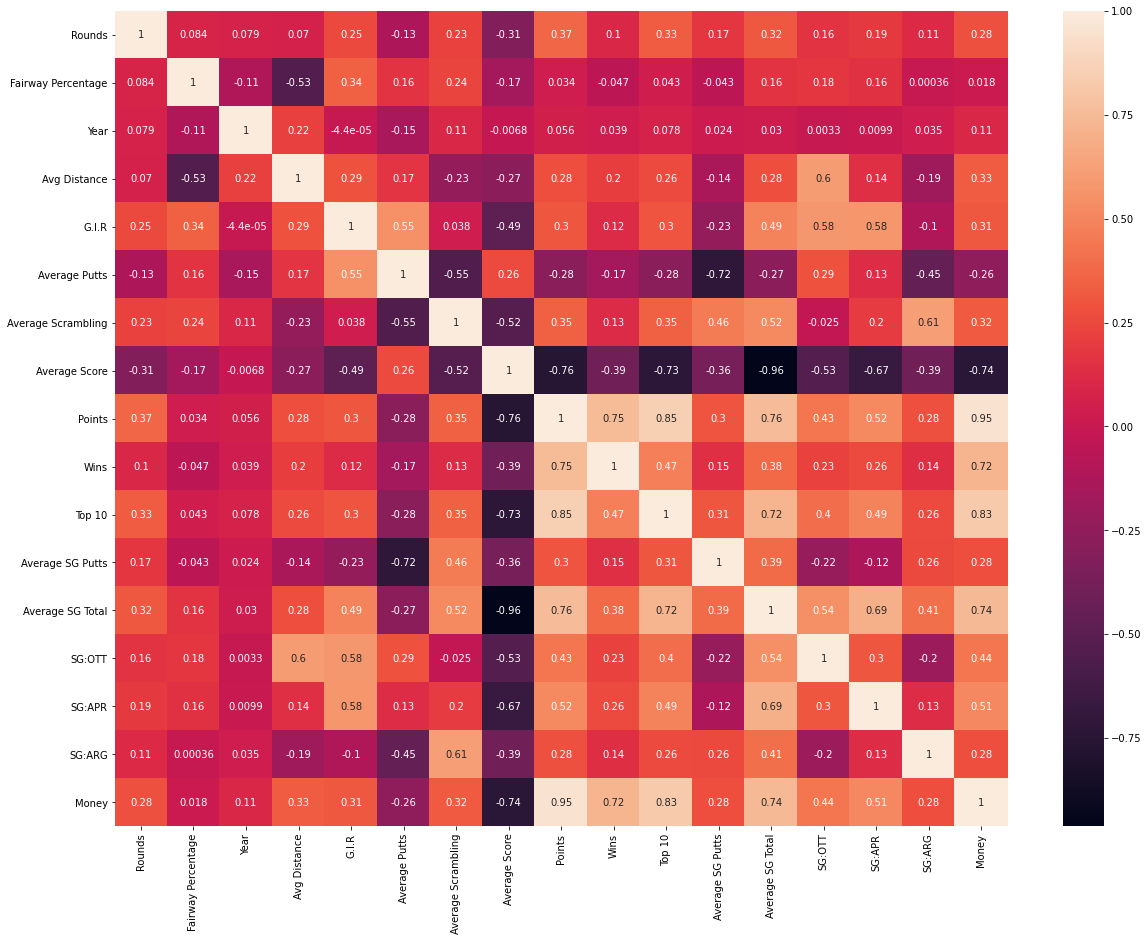

In [14]:
plt.subplots(figsize=(20,15))

sns.heatmap(df.corr(), annot = True)

From this heatmap we can see that Average Score, Points, Wins, Top 10's, and Average SG Total are all correlated to Money. These must be dropped from the features used for linear regression models later. 

In [15]:
df.columns

Index(['Player Name', 'Rounds', 'Fairway Percentage', 'Year', 'Avg Distance',
       'G.I.R', 'Average Putts', 'Average Scrambling', 'Average Score',
       'Points', 'Wins', 'Top 10', 'Average SG Putts', 'Average SG Total',
       'SG:OTT', 'SG:APR', 'SG:ARG', 'Money'],
      dtype='object')

In [16]:
features = ['Rounds', 'Fairway Percentage', 'Year', 'Avg Distance',
       'G.I.R', 'Average Putts', 'Average Scrambling', 'Average Score',
       'Points', 'Wins', 'Top 10', 'Average SG Putts', 'Average SG Total',
       'SG:OTT', 'SG:APR', 'SG:ARG', 'Money']

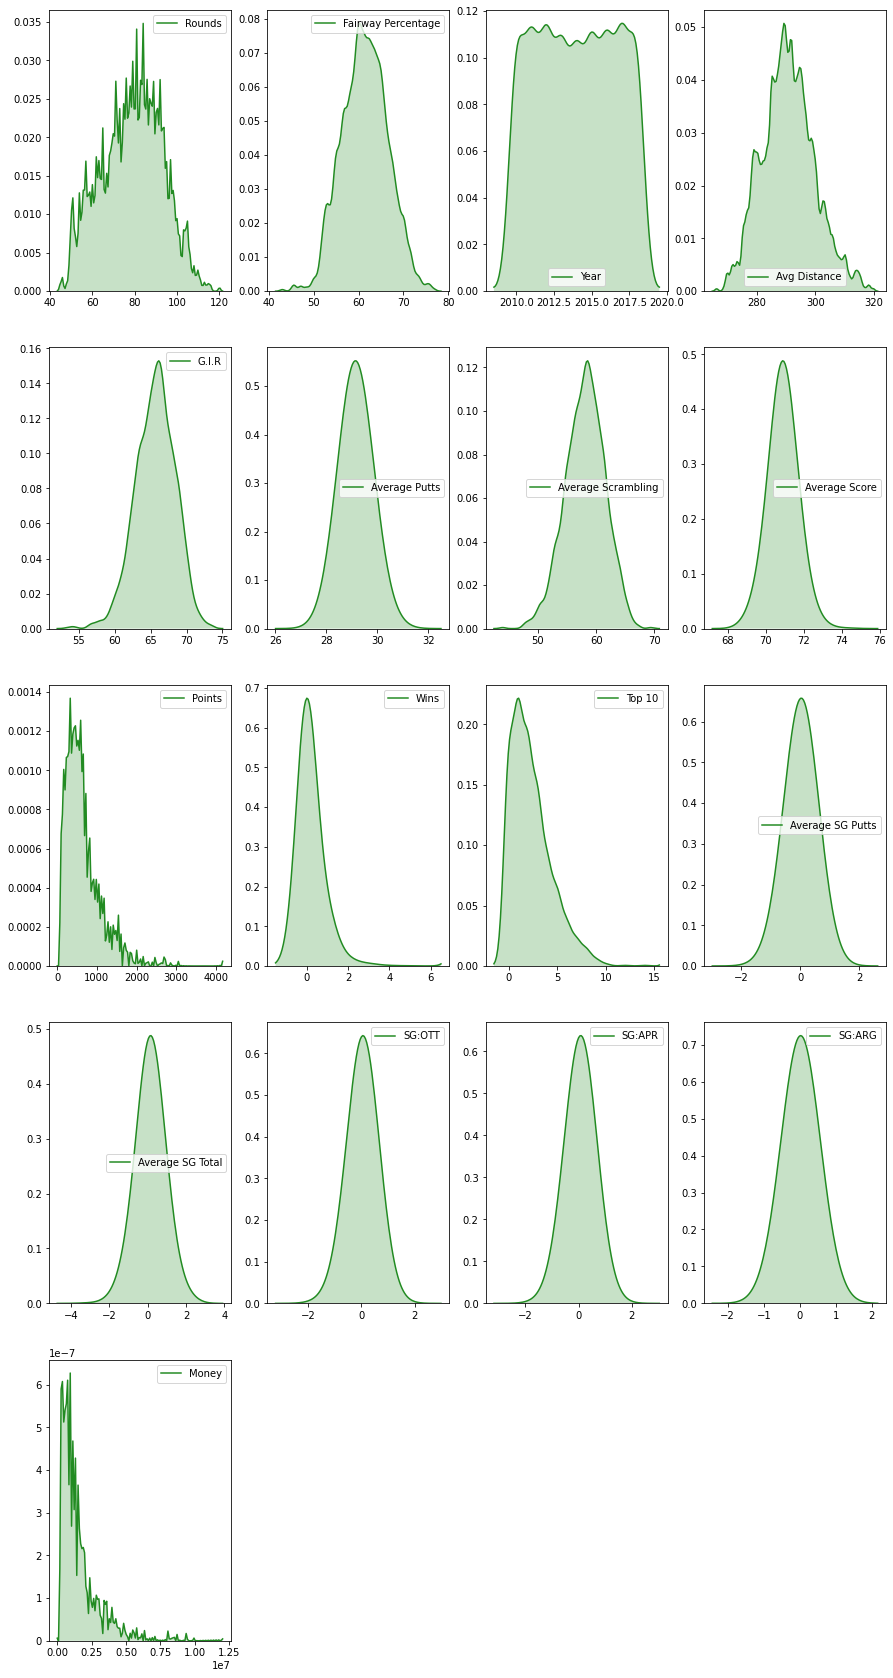

In [17]:
plt.figure(figsize=(15,30))
for i in enumerate(features):
    plt.subplot(5,4, i[0]+1)
    
    sns.kdeplot(df[i[1]], shade=True, bw=.5, color='forestgreen')

From the above plots we can see that the majority of the features appear normally distributed. We can also see that Money, Top 10's, Wins, and Points all have a long right tail which could indicate some outliers.

We will take care of the outliers below.

In [18]:
std = df['Money'].std() 
mean = df['Money'].mean()
    
cut_off = std * 3
lower, upper = mean - cut_off, mean + cut_off
    
df_new = df.drop(df[(df['Money'] > upper) & (df['Money'] < lower)].index)

We will now examine the changes in Distance over the years as well as the longest hitters. 

In [19]:
sns.set_style('whitegrid')

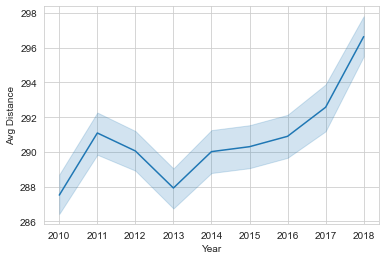

In [20]:
sns.lineplot(x= 'Year', y= 'Avg Distance', data= df)

Over the past 10 years we see a steady incerease over time in distance, this could be down to multiple causes such as equipment technology or player strength/fitness improvements. 

Interestingly we see a drop between 2011 and 2013, this could be down to new restrictions being placed on equipment however we do not know for sure. The decrease is also only 3 yards over two years therefore could be insufficient. 

In [21]:
distance = df[['Year','Player Name','Avg Distance',]].copy()

In [22]:
distance = distance.loc[distance.reset_index().groupby(['Year'])['Avg Distance'].idxmax()]

In [23]:
distance

,Year,Player Name,Avg Distance
1660,2010,Robert Garrigus,315.5
1481,2011,J.B. Holmes,318.4
1243,2012,Bubba Watson,315.5
1108,2013,Luke List,306.3
853,2014,Bubba Watson,314.3
732,2015,Dustin Johnson,317.7
561,2016,J.B. Holmes,314.5
350,2017,Rory McIlroy,316.7
162,2018,Rory McIlroy,319.7


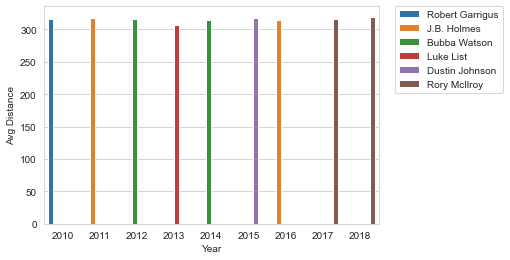

In [24]:
sns.barplot(x='Year', y='Avg Distance', data= distance, hue= 'Player Name')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

The previous lineplot showes the increase over the years in driving distance however when we inpect the distance increase via a barplot we see just how small these increments are year on year. 

From this lets look into SG:OOT to see if this high average distance is helping or hindering these players. 

In [25]:
distance1 = df[['Year','Player Name','SG:OTT',]].copy()

In [26]:
distance1.loc[distance1.reset_index().groupby(['Year'])['SG:OTT'].idxmax()]

,Year,Player Name,SG:OTT
1661,2010,Bubba Watson,0.798
1446,2011,Dustin Johnson,0.912
1243,2012,Bubba Watson,1.485
1055,2013,Bubba Watson,0.937
861,2014,Rory McIlroy,1.367
720,2015,Bubba Watson,1.194
459,2016,Rory McIlroy,1.230
336,2017,Dustin Johnson,1.071
124,2018,Dustin Johnson,0.919


We see the highest SG:OOT players over the years are also the familiar names we have seen on the highest average driving distance list previously, Dustin Johnson, Bubba Watson, and Rory Mcilroy. 

Looking at the correlation below for Average score and GIR we can see the importance of hitting the green in relation to scoring.

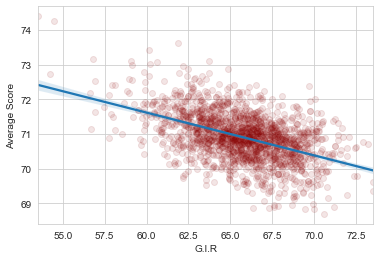

In [27]:
sns.regplot(x='G.I.R', y = 'Average Score', data = df, scatter_kws = {'color': 'darkred', 'alpha':0.1})

Finally lets look at what seperates the elite players from the average tour player. 

In [28]:
df['Elite'] = df.Wins >= 1

In [29]:
winners = df.groupby('Elite')[['Fairway Percentage', 'Avg Distance',
       'G.I.R', 'Average Putts', 'Average Scrambling', 'Average Score', 
       'Average SG Putts', 'Average SG Total',
       'SG:OTT', 'SG:APR', 'SG:ARG']].mean()

In [30]:
winners

,Fairway Percentage,Avg Distance,G.I.R,Average Putts,Average Scrambling,Average Score,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG
Elite,,,,,,,,,,,
False,61.516251,290.107670,65.558953,29.197699,57.975082,71.027651,0.006571,0.045204,0.001912,0.027513,0.009214
True,61.067456,294.258304,66.168021,28.993922,58.808481,70.400979,0.119647,0.655343,0.214463,0.249876,0.073018


In order to for the y axis scale to be appropriate i will seperate the 'SG' statistics from the remaining statistics, this will enable differences to be more visible on the lower end of the scale.

In [31]:
winners_stats = winners[['Fairway Percentage', 'Avg Distance',
       'G.I.R', 'Average Putts', 'Average Scrambling', 'Average Score']]

In [32]:
winners_SG = winners[['Average SG Putts', 'Average SG Total',
       'SG:OTT', 'SG:APR', 'SG:ARG']]

In [33]:
winners_stats = winners_stats.transpose()

In [34]:
winners_SG = winners_SG.transpose()

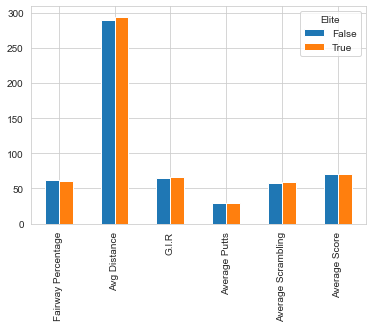

In [35]:
winners_stats.plot.bar()

As we can see above Fairway percentage hit and Average Putts do not appear to differ between the Elite players and the average tour player. We do see however that Driving distance is slightly higher as well as G.I.R and a lower Average Putts per round. 

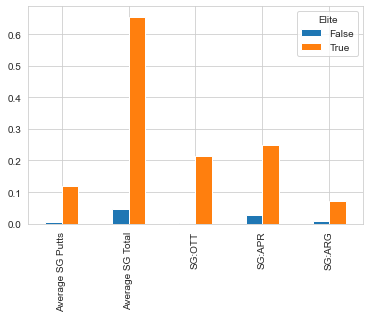

In [36]:
winners_SG.plot.bar()

The above bar chart really highlights the differences between the Elite players and the average tour player. We can clearly see that the players that win on tour really excel at the SG statistics. These are statistics representing how many shots these players gain on the field on average from different situations. On average it appears the Elite players are gaining 0.65 of a shot every round.

# 4. Models

For the modelling we will start with a simple Linear Regression model, for this we remove the features that have a strong correlation to the variable. 

In [37]:
X = df_new[['Rounds', 'Fairway Percentage', 'Year', 'Avg Distance',
       'G.I.R', 'Average Putts', 'Average Scrambling', 'Average SG Putts',
       'SG:OTT', 'SG:APR', 'SG:ARG',]]
y = df_new['Money']

## Linear Regression

In the following Linear Regression models we will scale the data to start. 

The Linear models include:

- Standard Linear Regression Model
- Linear Regression Model with polynomial features
- Ridge Regression with polynomial features and varying alpha values



### Standard Linear Regression

In [38]:
sc_X = StandardScaler()
X_train_SS = sc_X.fit_transform(X)

In [39]:
def linear_model(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    
    clf = LinearRegression().fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    print('R^2: {:.3f}'
          .format(clf.score(X_test, y_test)))
    print("Mean Absolute Error: {}".format(mean_absolute_error(y_test, y_pred)))

In [40]:
linear_model(X_train_SS, y)

R^2: 0.562
Mean Absolute Error: 693217.715785407


In [41]:
linear_model(X, y)

R^2: 0.562
Mean Absolute Error: 693217.7157854068


### Polynomial Features

In [42]:
poly = PolynomialFeatures(2)
poly = poly.fit(X)
poly_X = poly.transform(X)
print(poly_X.shape)

poly_X = pd.DataFrame(poly_X, columns = poly.get_feature_names(X.columns))

(1678, 78)


In [43]:
linear_model(poly_X, y)

R^2: 0.742
Mean Absolute Error: 506231.5573350861


### Ridge regression (alpha = 100, 1, 50) with Polynomial features

In [44]:
def linear_model_ridge(X, y, al):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state = 10)
    clf = Ridge(alpha = al).fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    print('R^2: {:.3f}'
          .format(clf.score(X_test, y_test)))
    print("Mean Absolute Error: {}".format(mean_absolute_error(y_test, y_pred)))

In [45]:
linear_model_ridge(poly_X, y, al = 100)

R^2: 0.760
Mean Absolute Error: 551603.664756361


In [46]:
linear_model_ridge(poly_X, y, al = 1)

R^2: 0.772
Mean Absolute Error: 543742.7110212056


In [47]:
linear_model_ridge(poly_X, y, al = 50)

R^2: 0.764
Mean Absolute Error: 549499.1517160747


Through the introduction of Polynomial Features, and Ridge Regression with an alpha value of 1 we were able to produce a model with an R^2 value of 0.77 on our test set. This score indicates a good predictive model without the risk of overfitting to the training set of data. This therefore indicates that this model will be more generalizable to new data sets.

## Random Forest Regression

The following models include:

- Random Forest Model
- Random Forest Model with a RandomizedSearchCV for Hyperparameter tuning 


In [48]:
x = df_new[['Rounds', 'Fairway Percentage', 'Year', 'Avg Distance',
       'G.I.R', 'Average Putts', 'Average Scrambling', 'Average Score',
       'Points', 'Wins', 'Top 10', 'Average SG Putts', 'Average SG Total',
       'SG:OTT', 'SG:APR', 'SG:ARG']]

rf = RandomForestRegressor(random_state = 42)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=42)

rf.fit(X_train, y_train);

In [49]:
prediction = rf.predict(X_test)

In [50]:
print("R^2: {}".format(rf.score(X_test, y_test)))

R^2: 0.935911450640914


In [51]:
print("Mean Absolute Error: {}".format(mean_absolute_error(y_test, prediction)))

Mean Absolute Error: 202154.83751984127


### Hyperparameter tuning 

In [52]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [53]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf2 = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 100, cv = 4, verbose=2, random_state=42, n_jobs = 1)

rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
[CV] n_estimators=170, min_samples_split=100, min_samples_leaf=2, max_features=sqrt, max_depth=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=170, min_samples_split=100, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.0s
[CV] n_estimators=170, min_samples_split=100, min_samples_leaf=2, max_features=sqrt, max_depth=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  n_estimators=170, min_samples_split=100, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   0.8s
[CV] n_estimators=170, min_samples_split=100, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=170, min_samples_split=100, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   0.9s
[CV] n_estimators=170, min_samples_split=100, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=170, min_samples_split=100, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   0.8s
[CV] n_estimators=110, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=25 
[CV]  n_estimators=110, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=25, total=   1.3s
[CV] n_estimators=110, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=25 
[CV]  n_estimators=110, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=25, total=   1.8s
[CV] n_estimators=110, min_samples_split=15

[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=10, max_features=sqrt, max_depth=20, total=   0.2s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=10, max_features=sqrt, max_depth=20 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=10, max_features=sqrt, max_depth=20, total=   0.1s
[CV] n_estimators=70, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=20 
[CV]  n_estimators=70, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=20, total=   0.4s
[CV] n_estimators=70, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=20 
[CV]  n_estimators=70, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=20, total=   0.4s
[CV] n_estimators=70, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=20 
[CV]  n_estimators=70, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=20, total=   0.4s
[CV] n_estimators=70, min_samples_split=15, min_samp

[CV]  n_estimators=10, min_samples_split=100, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   0.0s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   0.7s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   0.7s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   0.6s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   0.8s
[CV] n_estimators=160, min_samples_split=10, min_samples_le

[CV]  n_estimators=10, min_samples_split=15, min_samples_leaf=5, max_features=auto, max_depth=30, total=   0.1s
[CV] n_estimators=60, min_samples_split=100, min_samples_leaf=1, max_features=auto, max_depth=25 
[CV]  n_estimators=60, min_samples_split=100, min_samples_leaf=1, max_features=auto, max_depth=25, total=   0.5s
[CV] n_estimators=60, min_samples_split=100, min_samples_leaf=1, max_features=auto, max_depth=25 
[CV]  n_estimators=60, min_samples_split=100, min_samples_leaf=1, max_features=auto, max_depth=25, total=   0.5s
[CV] n_estimators=60, min_samples_split=100, min_samples_leaf=1, max_features=auto, max_depth=25 
[CV]  n_estimators=60, min_samples_split=100, min_samples_leaf=1, max_features=auto, max_depth=25, total=   0.4s
[CV] n_estimators=60, min_samples_split=100, min_samples_leaf=1, max_features=auto, max_depth=25 
[CV]  n_estimators=60, min_samples_split=100, min_samples_leaf=1, max_features=auto, max_depth=25, total=   0.5s
[CV] n_estimators=90, min_samples_split=5, m

[CV]  n_estimators=140, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5, total=   1.4s
[CV] n_estimators=120, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=120, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, total=   1.5s
[CV] n_estimators=120, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=120, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, total=   1.7s
[CV] n_estimators=120, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=120, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, total=   1.6s
[CV] n_estimators=120, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=120, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, total=   1.7s
[CV] n_estimators=190, min_samples_split=2, min_sampl

[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, total=   0.3s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, total=   0.3s
[CV] n_estimators=40, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20 
[CV]  n_estimators=40, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, total=   0.2s
[CV] n_estimators=40, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20 
[CV]  n_estimators=40, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, total=   0.2s
[CV] n_estimators=40, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20 
[CV]  n_estimators=40, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, total=   0.2s
[CV] n_estimators=40, min_samples_split=2, min_sampl

[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, total=   0.4s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30 
[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, total=   0.5s
[CV] n_estimators=110, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=20 
[CV]  n_estimators=110, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=20, total=   1.5s
[CV] n_estimators=110, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=20 
[CV]  n_estimators=110, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=20, total=   1.5s
[CV] n_estimators=110, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=20 
[CV]  n_estimators=110, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=20, total=   1.6s
[CV] n_estimators=110, min_samples_split=5, min_samp

[CV]  n_estimators=50, min_samples_split=15, min_samples_leaf=5, max_features=auto, max_depth=25, total=   0.5s
[CV] n_estimators=50, min_samples_split=15, min_samples_leaf=5, max_features=auto, max_depth=25 
[CV]  n_estimators=50, min_samples_split=15, min_samples_leaf=5, max_features=auto, max_depth=25, total=   0.5s
[CV] n_estimators=30, min_samples_split=100, min_samples_leaf=5, max_features=sqrt, max_depth=25 
[CV]  n_estimators=30, min_samples_split=100, min_samples_leaf=5, max_features=sqrt, max_depth=25, total=   0.1s
[CV] n_estimators=30, min_samples_split=100, min_samples_leaf=5, max_features=sqrt, max_depth=25 
[CV]  n_estimators=30, min_samples_split=100, min_samples_leaf=5, max_features=sqrt, max_depth=25, total=   0.1s
[CV] n_estimators=30, min_samples_split=100, min_samples_leaf=5, max_features=sqrt, max_depth=25 
[CV]  n_estimators=30, min_samples_split=100, min_samples_leaf=5, max_features=sqrt, max_depth=25, total=   0.1s
[CV] n_estimators=30, min_samples_split=100, m

[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20, total=   1.1s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20 
[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20, total=   0.9s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20 
[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20, total=   0.9s
[CV] n_estimators=70, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=25 
[CV]  n_estimators=70, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=   0.7s
[CV] n_estimators=70, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=25 
[CV]  n_estimators=70, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=   0.4s
[CV] n_estimators=70, min_samples_split=100

[CV]  n_estimators=120, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=5, total=   0.5s
[CV] n_estimators=120, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=5 
[CV]  n_estimators=120, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=5, total=   0.6s
[CV] n_estimators=120, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=5 
[CV]  n_estimators=120, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=5, total=   0.5s
[CV] n_estimators=170, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=15 
[CV]  n_estimators=170, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=15, total=   1.0s
[CV] n_estimators=170, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=15 
[CV]  n_estimators=170, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=15, total=   1.0s
[CV] n_estimators=170, min_samples_split=5, min

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  5.4min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [54]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=120, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [55]:
rf_random.best_score_

0.9224697401947992

In [56]:
rf_random.best_params_

{'n_estimators': 120,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10}

In [57]:
best_rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=120, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [58]:
best_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=120, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [59]:
prediction2 = best_rf.predict(X_test)

In [60]:
print("R^2: {}".format(best_rf.score(X_test, y_test)))

R^2: 0.9363726062593994


In [61]:
print("Mean Absolute Error: {}".format(mean_absolute_error(y_test, prediction2)))

Mean Absolute Error: 202604.97748167705


As we can see the Random Forest model produced a R^2 value of 0.94 and the hyperparameter tuning did not increase this by any significant amount. 

# 5. Conclusion

### Key points

From this notebook I aimed to discover what seperates the players with wins on tour from those players that do not.
I found that statistics such as Average Putts and Fairway percentages hit do not seem to differ much between the two groups of players. I found that Average Driving distance and G.I.R did however appear higher on average for tour winners indicating that distance from the tee is a important factor in todays modern game. Finally the most significant discovery was the difference between the SG statistics for the elite players against the average tour players. These are the statistics that really set apart the winners and would be a key area to focus on for even the average golfer to aim to improve there game.


### Predictive models

My aim with my machine learning models was to see if it was possible to predict a players earnings. Throughout my models I implemented multiple different methods including Linear regression, Ridge regression, and Random forest redgression. I found that my highest performing model was the Random forest model which produced a R^2 score of 0.94 with a MAE of only $202604.98. 

These results are great however are worrying that this model is overfitting to the training set and therefore will not generalise well to new data sets. I would suggest the best model was my ridge regression model with polynomial features and an alpha value of 1. This produced an R^2 value of 0.77 and a MAE of $543742.71. This is still a high scoring R^2 value and would have less bias than my Random Forest model. 


### Future Project

Having used regression and supervised machine learning models in this project in order to predict player earnings, I would like to apply an unsupervised clustering model to this dataset in order to classify player types. I would like to use this in combination with performance on different course types in order to predict what group of players will perform better each week depending on course set up. 